**Date:** 2019-3-22  
**Authors:** Zhanyuan Zhang  
**Purposes:** This experiment aims to accomplish the following things:
- Training a simple convolutional and recurrent hybrid network.
- Evaluate the performence of the hybrid network.

In [1]:
import os, shutil, pickle, shelve
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten, Conv1D, LSTM, CuDNNLSTM, Bidirectional
from keras.optimizers import RMSprop, Adam
from keras.initializers import glorot_normal

Using TensorFlow backend.


## 1. Data sampling and preparation

This part may get removed to another notebook in the future.

In [2]:
input_folder_path = "../../../temp/samples/"
output_folder_path = "../../../temp/buffers/"

# This should be the parent folder of motif files
motif_folder_path = "../../../Map_Motif_no_threshold_14Nov2018/"

# The shelve with motif as the outermost key
motif_species_shelve_path = "../../../temp/formatted/motif_dic"

# The shelve with species name as the outermost key
species_motif_shelve_path = "../../../temp/formatted/species_motif_dic"
# sample data from:
data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"

len(os.listdir(data_dir)) # total number of regions

3544

If need different set of samples, uncomment the following folded cells to perform sampling and saving data into a new buffer.  
**Note:** To make sure the number of samples is exactly `num_samples`, clear all the samples in the `input_folder_path`.

In [ ]:
!rm -r /home/ubuntu/data/temp/samples
!mkdir /home/ubuntu/data/temp/samples

**Helper functions for data processiong:**

In [3]:
def sampling(src, dest, num_samples, seed=42):
    """  
    Sample NUM_SAMPLES of data from SRC and copy them to DEST.
    Set random seed to be SEED.
    """
    np.random.seed(seed)
    all_data_lst = np.array(os.listdir(src))
    n = len(all_data_lst)
    sample_indices = np.random.choice(np.arange(n), num_samples, replace = False)
    sample_files = all_data_lst[sample_indices]

    for file in sample_files:
        shutil.copy(os.path.join(src, file),
                            dest)
    print('copied samples to {}'.format(dest))
        
def one_hot_encoding(input_folder_path, output_file_path, 
                     max_file_num=10000):
    """
    Given the data in INPUT_FOLDER_PATH, encode them and save
    as a buffer called OUTPUT_FILE_PATH.
    
    Note: INPUT_FOLDER_PATH is a directory while OUTPUT_FILE_PATH
          is a file.
    """
    # Use the following dictionary to perform the transformation
    base_pairs = {'A': [1, 0, 0, 0], 
                  'C': [0, 1, 0, 0],
                  'G': [0, 0, 1, 0],
                  'T': [0, 0, 0, 1],
                  'a': [1, 0, 0, 0],
                  'c': [0, 1, 0, 0],
                  'g': [0, 0, 1, 0],
                  't': [0, 0, 0, 1],
                  'n': [0, 0, 0, 0],
                  'N': [0, 0, 0, 0]}

    file_num_limit = max_file_num    # The maximum number of files to be decoded
    file_count = 0

    # Iterate through every file
    all_regions = []
    for file in os.listdir(input_folder_path):
        # When the number of file decoded has reached the limit, stop
        if file_count < file_num_limit:
            data = list(SeqIO.parse(input_folder_path + file,"fasta"))
            for n in range(0, len(data)):
                # Extract the header information
                header = data[n].description.split('|')
                descr = data[n].description
                regionID = header[0]
                expressed = header[1]
                speciesID = header[2]
                strand = header[3]
                # Complement all sequences in the negative DNA strand
    #             if strand == '-':
    #                 # Using the syntax [e for e in base_pairs[n]] to create a new pointer for each position
    #                 one_hot.append([descr, expressed, speciesID, [[e for e in base_pairs[n]] for n in data[n].seq.complement()]])
    #             else:
                all_regions.append([descr, expressed, speciesID, [[e for e in base_pairs[n]] for n in data[n].seq]])
            file_count += 1

    with open(output_file_path, mode="wb") as output:
        print("save to {}".format(output_file_path))
        pickle.dump(all_regions, output)
    return all_regions

def curtail(lst, read_len):
    """ A helper function of get_training_data
    """
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0])
    return lst

def get_training_data(input_data, output_folder_path,
                      max_len, train_x_name, train_y_name):
    """ 
    Convert INPUT_DATA to ready-to-be-fed training data and 
        corresponding labels.
    Save them to OUTPUT_FOLDER_PATH with name TRAIN_X_NAME and
        TRAIN_Y_NAME.
    INPUT_DATA is directly generated by the function one_hot_encoding. 
    """
    train_x, train_y = [], []
    for region in input_data:
        y, x = int(region[1]), region[3]
        x = curtail(x, max_len)  # Curtail
        x = np.array(x).flatten() # Flatten
        x = x.reshape((1000, 4)) # Reshape
        train_x.append(x)
        train_y.append(y)

    train_x, train_y = np.array(train_x), np.array(train_y)

    print(train_x.shape, train_y.shape)

    with open(os.path.join(output_folder_path, train_x_name), mode="wb") as output:
        print("save to {}".format(os.path.join(output_folder_path, train_x_name)))
        pickle.dump(train_x, output)

    with open(os.path.join(output_folder_path, train_y_name), mode="wb") as output:
        print("save to {}".format(os.path.join(output_folder_path, train_y_name)))
        pickle.dump(train_y, output)
    return train_x, train_y

def load_data(data_folder_path, train_x_name, train_y_name):
    output_name = train_x_name
    with open(os.path.join(output_folder_path, output_name), 'rb') as file:
        data_x = pickle.load(file)

    output_name = train_y_name
    with open(os.path.join(output_folder_path, output_name), 'rb') as file:
        data_y = pickle.load(file)

    print(data_x.shape, data_y.shape)
    
def data_split(data_x, data_y, val_split=0.2, seed=42):
    """
    Given totally N data, randomly sample N*VAL_SPLIT of them 
        to form validation data.
    Set random seed to SEED.
    """
    # Split it into training and validation data sets
    N = data_x.shape[0]
    num_val = int(N * val_split)
    
    np.random.seed(seed)
    val_indices = np.random.choice(np.arange(N), num_val, replace=False)
    train_indices = np.arange(N)[~np.isin(np.arange(N), val_indices)]

    train_x, train_y = data_x[train_indices], data_y[train_indices]
    val_x, val_y = data_x[val_indices], data_y[val_indices]
    
    print(N, train_x.shape, train_y.shape, val_x.shape, val_y.shape)
    return train_x, train_y, val_x, val_y

In [4]:
all_data_lst = np.array(os.listdir(data_dir))
num_samples = 209

sampling(data_dir, input_folder_path, num_samples, seed = 189)

output_file_path = os.path.join(output_folder_path, 'train.data')
train_regions = one_hot_encoding(input_folder_path, output_file_path)

data_x, data_y = get_training_data(train_regions, output_folder_path,
                                   max_len = 1000, 
                                   train_x_name = 'train_x.data', 
                                   train_y_name = 'train_y.data')

train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)

copied samples to ../../../temp/samples/
save to ../../../temp/buffers/train.data
(5016, 1000, 4) (5016,)
save to ../../../temp/buffers/train_x.data
save to ../../../temp/buffers/train_y.data
5016 (4013, 1000, 4) (4013,) (1003, 1000, 4) (1003,)


`train_x` has shape: (*# of training data*, *max length of sequence*, 4),
where the maximal length of sequence by default is 1000 and 4 reflects the one-hot encoding of one nucleotide(A, T, G, or C).

## 2. Model and configurations

In [7]:
def get_hybrid(opt):
    """  Return a hybrid network given a optimizer
    """
    model = Sequential()
    model.add(Conv1D(filters = 30, 
                     kernel_size = 15, 
                     padding = 'valid',
                     data_format = 'channels_last',
                     activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 5, strides = 5))
    model.add(Dropout(0.8)) # 0.2
    model.add(Bidirectional(LSTM(50))) # input_shape=(100, 50)
    model.add(Dropout(0.8)) # 0.5
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    return model

def train(model, train_x, train_y, val_data, config = {'epochs': 35, 'batch_size': 256}):
    """  Train model for a given config, training data, and validation data
    """
    epochs, batch_size = config['epochs'], config['batch_size']
    return model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=val_data)

def dianostic_plots(train_acc, train_loss, val_train_acc, val_loss):
    """  Plot dianostic plots of a model:
    Plot 1: Traning loss & validation loss against epochs
    Plot 2: Training acc & validation acc against epochs
    """
    epochs = range(1, len(train_acc) + 1)

    plt.plot(epochs, train_acc, '-', label='Training train_accuracy')
    plt.plot(epochs, val_train_acc, '-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoches')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, '-', label='Training Loss')
    plt.plot(epochs, val_loss, '-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoches')
    plt.legend()
    
    plt.show()

### 2.1 Training and Tuning

In [8]:
# Set up some configurations
optimizers = {'adam': Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-2, amsgrad=False),
              'rmsprop': RMSprop(lr=1e-2, rho=0.9, epsilon=None, decay=1e-2)}

model_prefix = ['hybrid']

In [9]:
# Start training
opt = optimizers['rmsprop']
model = get_hybrid(opt)
history = train(model, train_x, train_y, (val_x, val_y))

Train on 4013 samples, validate on 1003 samples
Epoch 1/35
4013/4013 [==============================] - 26s 7ms/step - loss: 0.7404 - acc: 0.5121 - val_loss: 0.7023 - val_acc: 0.5075
Epoch 2/35
4013/4013 [==============================] - 24s 6ms/step - loss: 0.6768 - acc: 0.5405 - val_loss: 0.6913 - val_acc: 0.5075
Epoch 3/35
4013/4013 [==============================] - 24s 6ms/step - loss: 0.6605 - acc: 0.5497 - val_loss: 0.6515 - val_acc: 0.5573
Epoch 4/35
4013/4013 [==============================] - 24s 6ms/step - loss: 0.6610 - acc: 0.5522 - val_loss: 0.6527 - val_acc: 0.5723
Epoch 5/35
4013/4013 [==============================] - 25s 6ms/step - loss: 0.6617 - acc: 0.5460 - val_loss: 0.6525 - val_acc: 0.5095
Epoch 6/35
4013/4013 [==============================] - 24s 6ms/step - loss: 0.6597 - acc: 0.5535 - val_loss: 0.6496 - val_acc: 0.5643
Epoch 7/35
4013/4013 [==============================] - 24s 6ms/step - loss: 0.6510 - acc: 0.5622 - val_loss: 0.6452 - val_acc: 0.6112
Epoch 8

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 986, 30)           1830      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 197, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 197, 30)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               32400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total para

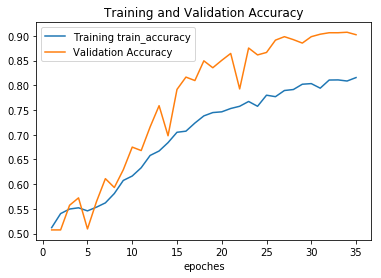

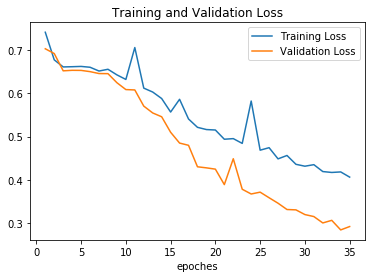

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

dianostic_plots(acc, loss, val_acc, val_loss)

In [12]:
# Save the model for later analysis
save_model_path = '/home/ubuntu/data/team_neural_network/code/models'
model_name = 'hybrid_net'
model.save(os.path.join(save_model_path, model_name))

## 3. Evaluation

In [ ]:
!rm -r /home/ubuntu/data/temp/test
!mkdir /home/ubuntu/data/temp/test

In [13]:
all_data_lst = np.array(os.listdir(data_dir))
num_samples = 209

test_folder_path = '/home/ubuntu/data/temp/test/'
sampling(data_dir, test_folder_path, num_samples, seed = 182)

output_file_path = os.path.join(output_folder_path, 'test.data')
test_regions = one_hot_encoding(test_folder_path, output_file_path)

test_x, test_y = get_training_data(test_regions, output_folder_path,
                                   max_len = 1000, 
                                   train_x_name = 'test_x.data', 
                                   train_y_name = 'test_y.data')

copied samples to /home/ubuntu/data/temp/test/
save to ../../../temp/buffers/test.data
(5016, 1000, 4) (5016,)
save to ../../../temp/buffers/test_x.data
save to ../../../temp/buffers/test_y.data


In [14]:
model.metrics_names

['loss', 'acc']

In [15]:
model.evaluate(x = test_x, y = test_y)

5016/5016 [==============================] - 13s 3ms/step


[0.9070065562899984, 0.5572169059011164]

**Conclusion:**  
The model performs poorly on test set, even though it performs well on validation set. Note that the training data and validation data are actually a partition of the sequences in the sampled regions, and thus it's highly possible that the model never gets trained on those regions of test set since we sampled testing regions separately. This implies that either the model fails to learn the correlation among different regions, or the sequences coming from different regions have different distributions.  

**TODO:**  
- Optimize the model.
- Try training the model on more regions then do validation on other regions that are not in the training set.
- Check the similarity of the sequences among 24 species in one region.
- (Optional) Write an API for data processing based on the helper functions defined in this experiment.